Displaying 3 Benign Images:


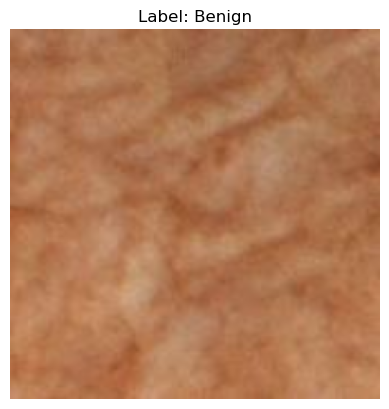

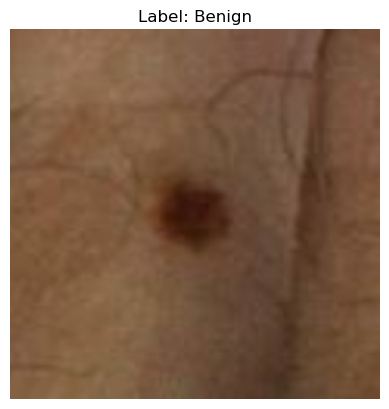

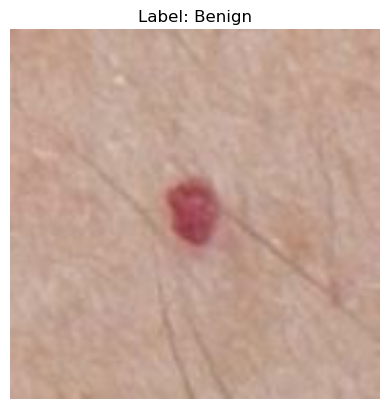


Displaying 3 Malignant Images:


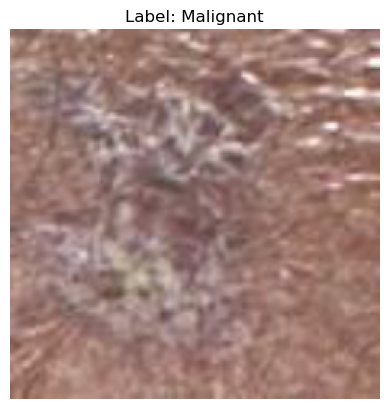

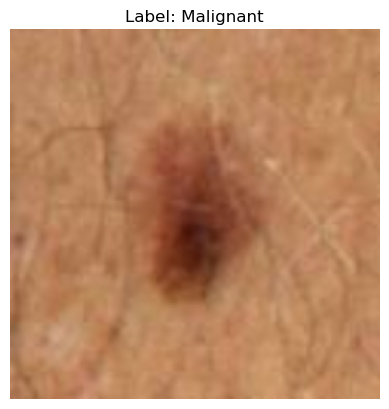

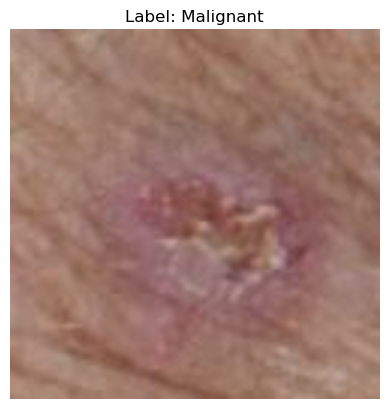

In [18]:
import matplotlib.pyplot as plt

# Function to display an image and its label
def display_image(isic_id, label, hdf5_file):
    image = load_and_augment_image_from_hdf5(isic_id, augment=False)  # No augmentation, just display
    plt.imshow(image.numpy())
    plt.title(f"Label: {'Malignant' if label == 1.0 else 'Benign'}")
    plt.axis('off')
    plt.show()

# Display the first 3 Benign images
print("Displaying 3 Benign Images:")
benign_images = train_df[train_df['iddx_1'] == 'Benign'].head(3)
for index, row in benign_images.iterrows():
    isic_id = row['isic_id']
    label = 0.0  # Benign
    display_image(isic_id, label, hdf5_file)

# Display the first 3 Malignant images
print("\nDisplaying 3 Malignant Images:")
malignant_images = train_df[train_df['iddx_1'] == 'Malignant'].head(3)
for index, row in malignant_images.iterrows():
    isic_id = row['isic_id']
    label = 1.0  # Malignant
    display_image(isic_id, label, hdf5_file)


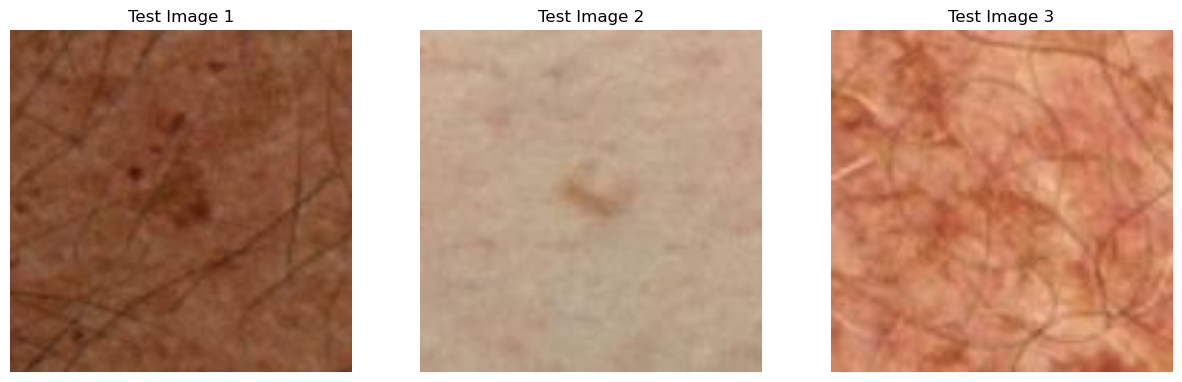

In [24]:
# Load the test HDF5 file
test_hdf5_file_path = r'C:/Users/nirmi/test-image.hdf5'
test_hdf5_file = h5py.File(test_hdf5_file_path, 'r')

# Function to display images from the test HDF5 file
def display_test_images(hdf5_file, num_images=3):
    plt.figure(figsize=(15, 5))
    for i, key in enumerate(list(hdf5_file.keys())[:num_images]):
        image_data = hdf5_file[key][()]
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = image / 255.0  # Normalize to [0, 1]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Test Image {i + 1}")
        plt.axis('off')
    
    plt.show()

# Display the first 3 images from the test set
display_test_images(test_hdf5_file)


In [28]:
# Load the metadata CSV
metadata = pd.read_csv(
    r'C:/Users/nirmi/train-metadata.csv',
    dtype={
        'isic_id': str, 
        'iddx_1': str
    },
    low_memory=False
)

# Ensure consistent formatting of isic_id
metadata['isic_id'] = metadata['isic_id'].str.strip().str.upper()

# Drop columns 51 and 52 (if needed)
if len(metadata.columns) > 52:
    metadata = metadata.drop(columns=[metadata.columns[51], metadata.columns[52]])

# Filter out rows that are neither 'Benign' nor 'Malignant'
metadata = metadata[metadata['iddx_1'].isin(['Benign', 'Malignant'])]

# Display the first few rows of the train CSV file
print("Train CSV File Head:")
print(metadata.head())


Train CSV File Head:
        isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3D: white  20.244422  ...   
1                    1.10  TBP tile: close-up     3D: white  31.712570  ...   
2                    3.40  TBP tile: close-up        3D: XP  22.575830  ...   
3                    3.22  TBP tile: close-up        3D: XP  14.242329  ...   
4                    2.73  TBP tile: close-up     3D: white  24.725520  ...   

                              attribution

In [30]:
# Function to show HDF5 file details
def show_hdf5_file_details(hdf5_file):
    print(f"HDF5 File: {hdf5_file.filename}")
    print("Keys available in the HDF5 file:", list(hdf5_file.keys()))
    
    # Example of showing the shape and datatype of the first entry in the HDF5 file
    first_key = list(hdf5_file.keys())[0]
    first_data = hdf5_file[first_key]
    print(f"First entry key: {first_key}")
    print(f"Shape of the first entry: {first_data.shape}")
    print(f"Datatype of the first entry: {first_data.dtype}")

# Load the train HDF5 file
hdf5_file_path = r'C:/Users/nirmi/train.hdf5'
hdf5_file = h5py.File(hdf5_file_path, 'r')

# Display the details of the HDF5 file
show_hdf5_file_details(hdf5_file)


HDF5 File: C:/Users/nirmi/train.hdf5


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



First entry key: ISIC_0015670
Shape of the first entry: ()
Datatype of the first entry: |S3325


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the metadata CSV
metadata = pd.read_csv(
    r'C:/Users/nirmi/train.csv',
    dtype={
        'isic_id': str, 
        'iddx_1': str
    },
    low_memory=False
)

# Ensure consistent formatting of isic_id
metadata['isic_id'] = metadata['isic_id'].str.strip().str.upper()

# Drop columns 51 and 52
metadata = metadata.drop(columns=[metadata.columns[51], metadata.columns[52]])

# Filter out rows that are neither 'Benign' nor 'Malignant'
metadata = metadata[metadata['iddx_1'].isin(['Benign', 'Malignant'])]

# Load HDF5 file
hdf5_file_path = r'C:/Users/nirmi/train-image.hdf5'
hdf5_file = h5py.File(hdf5_file_path, 'r')

# Drop rows where isic_id is not found in the HDF5 file
valid_isic_ids = set(hdf5_file.keys())
metadata = metadata[metadata['isic_id'].isin(valid_isic_ids)]

# Split the data into train and validation sets
train_df, val_df = train_test_split(metadata, test_size=0.2, random_state=42)

# Data augmentation generator for malignant class
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to load and augment images from HDF5
def load_and_augment_image_from_hdf5(isic_id, augment=False):
    if isic_id in hdf5_file:
        image_data = hdf5_file[isic_id][()]
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = image / 255.0  # Normalize to [0, 1]
        
        if augment:
            image = image.numpy()  # Convert to NumPy array
            image = augmenter.random_transform(image)
            image = tf.convert_to_tensor(image)  # Convert back to TensorFlow tensor
        
        return image
    else:
        raise ValueError(f"isic_id {isic_id} not found in HDF5 file")

# Function to create a dataset from the metadata and HDF5 file with augmentation for malignant cases
def create_augmented_image_dataset(df, batch_size=32):
    def generator():
        for index, row in df.iterrows():
            augment = row['iddx_1'] == 'Malignant'
            try:
                image = load_and_augment_image_from_hdf5(row['isic_id'], augment=augment)
                label = 1.0 if row['iddx_1'] == 'Malignant' else 0.0
                yield image, label
            except ValueError as e:
                print(e)  # Print the error message and skip this entry
                continue
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    return dataset

# Combine malignant and benign datasets
augmented_train_df = pd.concat([train_df[train_df['iddx_1'] == 'Malignant'], train_df[train_df['iddx_1'] == 'Benign']])

# Create the train and validation image datasets with augmentation for malignant class
train_image_dataset = create_augmented_image_dataset(augmented_train_df)
val_image_dataset = create_augmented_image_dataset(val_df)

# Define the model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with class weights
class_weights = {0: 1.0, 1: 10.0}  # Adjust these weights according to your dataset

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate steps per epoch and validation steps
train_steps_per_epoch = len(augmented_train_df) // 32
val_steps_per_epoch = len(val_df) // 32

# Train the model
history = model.fit(
    train_image_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=5,  # Train for more epochs
    validation_data=val_image_dataset,
    validation_steps=val_steps_per_epoch,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate model
y_val_pred = model.predict(val_image_dataset)
y_val_pred_classes = (y_val_pred > 0.5).astype(int)  # Adjust the threshold if needed

# Generate confusion matrix and classification report
y_val_true = val_df['iddx_1'].apply(lambda x: 1 if x == 'Malignant' else 0).values
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)
print(conf_matrix)
print(classification_report(y_val_true, y_val_pred_classes))


Epoch 1/5
10023/10023 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9836 - loss: 0.0763

KeyboardInterrupt: 

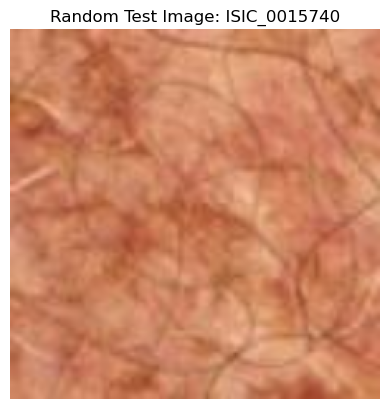

In [34]:
import random

# Load the test HDF5 file
test_hdf5_file_path = r'C:/Users/nirmi/test-image.hdf5'
test_hdf5_file = h5py.File(test_hdf5_file_path, 'r')

# Select a random image from the test HDF5 file
random_isic_id = random.choice(list(test_hdf5_file.keys()))

# Function to load an image from the HDF5 file
def load_image_from_hdf5(isic_id, hdf5_file):
    if isic_id in hdf5_file:
        image_data = hdf5_file[isic_id][()]
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = image / 255.0  # Normalize to [0, 1]
        return image
    else:
        raise ValueError(f"isic_id {isic_id} not found in HDF5 file")

# Load the random image
random_image = load_image_from_hdf5(random_isic_id, test_hdf5_file)

# Display the random image
plt.imshow(random_image.numpy())
plt.title(f"Random Test Image: {random_isic_id}")
plt.axis('off')
plt.show()


In [36]:
# Expand dimensions to match the model's expected input shape (batch size, height, width, channels)
random_image_batch = tf.expand_dims(random_image, axis=0)

# Predict the label
predicted_prob = model.predict(random_image_batch)
predicted_class = (predicted_prob > 0.5).astype(int)  # 0 for Benign, 1 for Malignant

# Map the predicted class to a label
predicted_label = 'Malignant' if predicted_class == 1 else 'Benign'

print(f"Predicted Label for Image {random_isic_id}: {predicted_label} (Probability: {predicted_prob[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Label for Image ISIC_0015740: Benign (Probability: 0.0000)
